<a href="https://colab.research.google.com/github/irfansalini/DLCV_Workshop/blob/main/Object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Object Localization

The fascinating part about localization is the simplicity it has compared to object detection models. Definitely, object detection models deal with a much bigger problem, and have to run classification for all the regions suggested by the initial region selection layer in certain architectures. Still, the idea that we can predict the coordinates like a regression problem is interesting. So our general architecture, which is similar to an image classification model, will have additionally 1 regression output (with 4 coordinates) training in parallel towards getting the coordinates.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig51.png)

### Dataset for Localization

For object localization, we will need not just the image and label, but also the coordinates of the bounding box containing the object. We must use image annotation/object tagging tools for preparing such a dataset, and XML is a popular file format used to store coordinate values of each image.

One of the more popular object tagging tools is Microsoft's open source object tagging tool, VOTT. It is lightweight and simple which makes it perfect for localization problems. [Here](https://github.com/microsoft/VoTT) is the link to the project and the documentation.

It is not compulsory that you store the data as XML, you can choose any file type which you are comfortable handling for data reading, but XMLs work like a charm. Our inputs will be the image, its label, and four values corresponding to the coordinates we are tagging. For this project, I extracted a part of the popular Dogs vs. Cats Dataset, and created bounding boxes using VOTT and generated XML files. We shall discuss in detail how we can read those XML files to obtain the input coordinates for the corresponding image with the power of python and some libraries.

### PyTorch Implementation

As usual, we are starting off with importing libraries including pandas, CSV, and XML which will help us work on the inputs.

In [2]:
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os

from PIL import Image

import pandas as pd
from xml.dom import minidom
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


You can download the dataset used to demonstrate this object localization implementation from [here](https://drive.google.com/file/d/1RVoLlMGx_qqxclsnUgWSoYn8t2McaFJK/view). When implementing for your personal projects, alter the dataset and populate it with more images and annotations for reliable model performance. As we had to create bounding boxes for the sake of the demo, we have kept the samples to a minimum.

Let us analyze the XML file before reading and processing the inputs. Understanding the structure will help you understand how to read a new XML when you encounter it.

<annotation verified="yes">
    <folder>Annotation</folder>
    <filename>cat.0.jpg</filename>
    <path>Cat-PascalVOC-export/Annotations/cat.0.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>256</width>
        <height>256</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
    <name>cat</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
        <xmin>55.35820533192091</xmin>
        <ymin>10.992090947210452</ymin>
        <xmax>197.38757944915255</xmax>
        <ymax>171.24521098163842</ymax>
    </bndbox>
</object>
</annotation>

Next, let's jump into reading and processing the images and annotations. We shall use  XML minidom to read xml files.

In [4]:
def extract_xml_contents(annot_directory, image_dir):
        
        file = minidom.parse(annot_directory)

        # Get the height and width for our image
        height, width = cv2.imread(image_dir).shape[:2]

        # Get the bounding box co-ordinates 
        xmin = file.getElementsByTagName('xmin')
        x1 = float(xmin[0].firstChild.data)

        ymin = file.getElementsByTagName('ymin')
        y1 = float(ymin[0].firstChild.data)

        xmax = file.getElementsByTagName('xmax')
        x2 = float(xmax[0].firstChild.data)

        ymax = file.getElementsByTagName('ymax')
        y2 = float(ymax[0].firstChild.data)

        class_name = file.getElementsByTagName('name')

        if class_name[0].firstChild.data == "cat":
          class_num = 0
        else:
          class_num = 1

        files = file.getElementsByTagName('filename')
        filename = files[0].firstChild.data

        # Return the extracted attributes
        return filename,  width, height, class_num, x1,y1,x2,y2

Let us create a num_to_labels dictionary for retrieving the labels from predictions.

In [5]:
num_to_labels= {0:'cat',1:'dog'}



Once we get all this data, we can store this as a CSV, so that we don't have to read the XML files for each run of training. We shall use a Pandas data frame for storing the data which we shall later save as a CSV.

In [6]:
# Function to convert XML files to CSV
def xml_to_csv():

  # List containing all our attributes regarding each image
  xml_list = []

  # We loop our each class and its labels one by one to preprocess and augment 
  image_dir = '/content/drive/MyDrive/localization_dataset/dataset/images'
  annot_dir = '/content/drive/MyDrive/localization_dataset/dataset/annot'

  # Get each file in the image and annotation directory
  mat_files = os.listdir(annot_dir)
  img_files = os.listdir(image_dir)

  # Loop over each of the image and its label
  for mat, image_file in zip(mat_files, img_files):
      
      # Full mat path
      mat_path = os.path.join(annot_dir, mat)

      # Full path Image
      img_path = os.path.join(image_dir, image_file)

      # Get Attributes for each image 
      value = extract_xml_contents(mat_path, img_path)

      # Append the attributes to the mat_list
      xml_list.append(value)

  # Columns for Pandas DataFrame
  column_name = ['filename', 'width', 'height', 'class_num', 'xmin', 'ymin', 
                 'xmax', 'ymax']

  # Create the DataFrame from mat_list
  xml_df = pd.DataFrame(xml_list, columns=column_name)

  # Return the dataframe
  return xml_df

# The Classes we will use for our training
classes_list = sorted(['cat',  'dog'])

# Run the function to convert all the xml files to a Pandas DataFrame
labels_df = xml_to_csv()

# Saving the Pandas DataFrame as CSV File
labels_df.to_csv(('dataset.csv'), index=None)

Now that we got the data in the CSV, let us load the corresponding images and labels for building data loaders. We will be pre-processing images, including normalizing the pixels. One thing to note here is how we store the coordinates. We are storing the value as a 0 to 1 range value by dividing it with image size (256 here) so that the model output can be scaled to any image later (we will see this in the visualization part).  

In [7]:
def preprocess_dataset():
  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []

  h = 256
  w = 256
  image_dir = '/content/drive/MyDrive/localization_dataset/dataset/images'

  with open('dataset.csv') as csvfile:
      rows = csv.reader(csvfile)
      columns = next(iter(rows))
      for row in rows:
        labels.append(int(row[3]))
        #Scaling Coordinates to the range of [0,1] by dividing the coordinate with image size, 256 here.
        arr = [float(row[4])/256,  
               float(row[5])/256,
               float(row[6])/256,
               float(row[7])/256]
        boxes.append(arr)
        img_path = row[0]
        # Read the image
        img  = cv2.imread(os.path.join(image_dir,img_path))

        # Resize all images to a fix size
        image = cv2.resize(img, (256, 256))

        # # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize the image by dividing it by 255.0 
        image = image.astype("float") / 255.0

        # Append it to the list of images
        img_list.append(image)

  return labels, boxes, img_list

Now that function is ready, let us call it and load the data for inputs. As a final step of Data Preprocessing, we shall shuffle the data.

In [8]:
# All images will resized to 256, 256 
image_size = 256

# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset()

# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, labels))
random.shuffle(combined_list)

# Extract back the contents of each list
img_list, boxes, labels = zip(*combined_list)

So far we have completed the data preprocessing involving reading the data annotations from XML files and now we are ready to proceed with building custom Data Loaders in PyTorch and Model Architecture design. 

### Dataset Visualization

Let us visualize the dataset with the bounding boxes before getting into the machine learning portion of this tutorial. Here we can see how to retrieve the coordinates through multiplication with image size. We are using OpenCV to display the image. This will print out a sampling of 20 images with their bounding boxes.

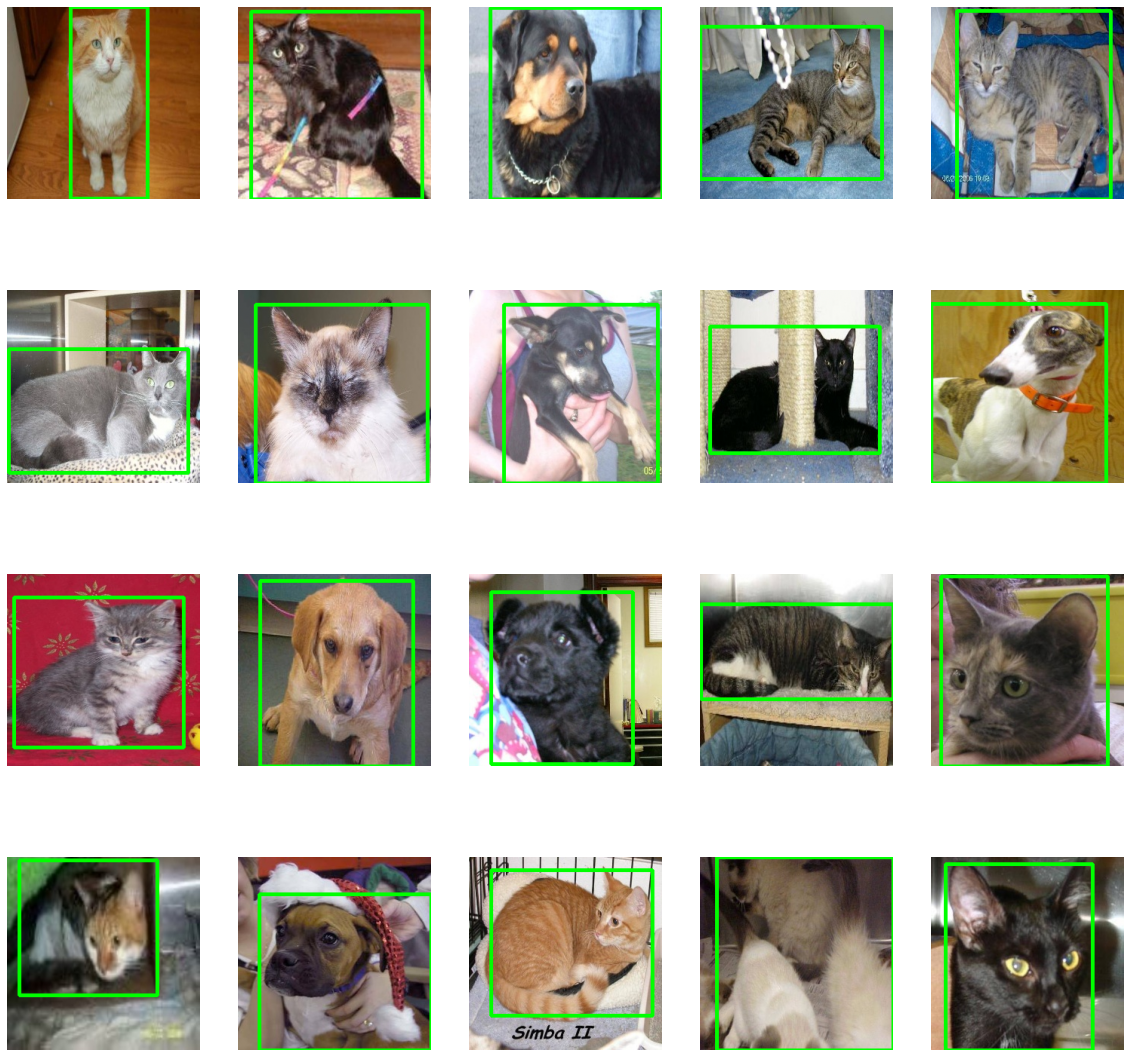

In [9]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(img_list)), 20)

for itr, i in enumerate(random_range, 1):

    # Bounding box of each image
    a1, b1, a2, b2 = boxes[i];
    img_size = 256

    # Rescaling the boundig box values to match the image size
    x1 = a1 * img_size
    x2 = a2 * img_size
    y1 = b1 * img_size
    y2 = b2 * img_size

    # The image to visualize
    image = img_list[i]

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3);
    
    # Clip the values to 0-1 and draw the sample of images
    img = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, itr);
    plt.imshow(img);
    plt.axis('off');

### Dataset Splitting

We have got our dataset in img_list, labels, and boxes, and now we must split the dataset before we jump on to DataLoaders. As usual, we shall use the `train_test_split` method from the sklearn library for this task.

In [10]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(labels), np.array(boxes), test_size = 0.2, 
                random_state = 43)

print('Training Images Count: {}, Validation Images Count: {}'.format(
    len(train_images), len(val_images) ))

Training Images Count: 960, Validation Images Count: 240


Now we have gotten a quick glance at our dataset through visualization, and we have completed dataset splitting. Let us move on to building our custom PyTorch DataLoaders for our dataset, which is currently scattered around in variables.

### Custom DataLoaders in Pytorch

DataLoaders, as the name suggests, return an object that will handle the entire data provision system while we will be training the model. It provides features like shuffle while creating the object, it has a 'getitem' method which handles what should be your data input in each iteration, and all these things let you engineer everything the way you wish without making the code messy in the training part. This allows you to focus on other optimizations more. Let us start the PyTorch section with imports.

In [11]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle
import random
import time

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
class Dataset():
    def __init__(self, train_images, train_labels, train_boxes):
        self.images = torch.from_numpy(train_images).float()
        self.images = self.images.permute(0,3,1,2)
        self.labels = torch.from_numpy(train_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(train_boxes).float()

    def __len__(self):
        return len(self.labels)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.labels[idx],
              self.boxes[idx])

# Inheriting from Dataset class

class ValDataset(Dataset):

    def __init__(self, val_images, val_labels, val_boxes):

        self.images = torch.from_numpy(val_images).float()
        self.images = self.images.permute(0,3,1,2)
        self.labels = torch.from_numpy(val_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(val_boxes).float()

Here we will create the Dataset class, first by loading the image, labels, and the boxes coordinates, scaled into the range of
0-1 to class variables. We then use the  'getitem' to design the loader output in each iteration. Similarly, we shall build the ValDataset (validation dataset) DataLoader class. As the structure and the nature of data is the same, we will inherit from the above class.

Now that we have the Classes of DataLoaders, let us right away create the data loader objects from the respective classes.

In [14]:
dataset = Dataset(train_images, train_labels, train_boxes)
valdataset = ValDataset(val_images, val_labels, val_boxes)

Now that we have completed our journey with preparing the data, let us move to the Machine Learning model part of the tutorial. We will be doing the object localization implementation using a fairly simple set of Convolutional Neural Networks, and this will help us adapt the concept to our understanding. We can experiment with various aspects of this architecture including using a pre-trained model like Alexnet. I would encourage you to learn more about optimizers, loss functions, and hyper tuning models to master the skill of architecture design for future projects.

### Model Architecture

So to understand how we have to design the architecture, we have to first understand input and outputs. Here the input is a batch of images, so it will be stylized like  (BS, C, H, W). BS being Batch Size and then Channels, Height, and Weight. The order is important, as in PyTorch that's how images are stored. In TensorFlow, it is (H, W, C) for each image.

Coming to outputs, we have 2 outputs as we have been discussing since the beginning of the previous blog. First is your classification output which will be of size (1, N), N being the number of classes. The second output is of size (1, 4) which is xmin, ymin, xmax, and ymax but in the range of (0,1). This helps you scale the coordinates according to image size later. So the output will be (CLF, BOX), the first being classification as discussed above, and the other coordinates.

Now, interpreting from the Machine Learning part, CLF will be used to get the class index by using argmax on the output, and we can add a softmax activation function at the end for probabilistic outputs. BOX outputs will be generated after passing through the sigmoid activation function which makes the range (0,1). That said, everything else is similar to a conventional image classification model. Let's look at the code.

In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # CNNs for rgb images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=5)


        # Connecting CNN outputs with Fully Connected layers for classification
        self.class_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.class_fc2 = nn.Linear(in_features=240, out_features=120)
        self.class_out = nn.Linear(in_features=120, out_features=2)

        # Connecting CNN outputs with Fully Connected layers for bounding box
        self.box_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.box_fc2 = nn.Linear(in_features=240, out_features=120)
        self.box_out = nn.Linear(in_features=120, out_features=4)


    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)

        t = torch.flatten(t,start_dim=1)
        

        class_t = self.class_fc1(t)
        class_t = F.relu(class_t)

        class_t = self.class_fc2(class_t)
        class_t = F.relu(class_t)

        class_t = F.softmax(self.class_out(class_t),dim=1)

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        box_t = F.sigmoid(box_t)

        return [class_t,box_t]

Let us next instantiate the model, and get it to use the GPU(s) if available. This can really accelerate the training process, especially for a huge objective like image localization. We shall also see the model summary after that.

In [16]:
model = Network()
model = model.to(device)
model

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 192, kernel_size=(5, 5), stride=(1, 1))
  (class_fc1): Linear(in_features=1728, out_features=240, bias=True)
  (class_fc2): Linear(in_features=240, out_features=120, bias=True)
  (class_out): Linear(in_features=120, out_features=2, bias=True)
  (box_fc1): Linear(in_features=1728, out_features=240, bias=True)
  (box_fc2): Linear(in_features=240, out_features=120, bias=True)
  (box_out): Linear(in_features=120, out_features=4, bias=True)
)

Now, we can write a small function to calculate the number of correct predictions for each batch of training.

In [17]:
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

Now we shall create the data loaders for both training and validation datasets for feeding batches of images while training.

In [18]:
dataloader = torch.utils.data.DataLoader(
       dataset, batch_size=32, shuffle=True)
valdataloader = torch.utils.data.DataLoader(
       valdataset, batch_size=32, shuffle=True)

### Model Training and Validation

In [19]:
def train(model):
    # Defining the optimizer
    optimizer = optim.SGD(model.parameters(),lr = 0.1)
    num_of_epochs = 30
    epochs = []
    losses = []
    # Creating a directory for storing models
    os.mkdir('models')
    for epoch in range(num_of_epochs):
        tot_loss = 0
        tot_correct = 0
        train_start = time.time()
        model.train()
        for batch, (x, y, z) in enumerate(dataloader):
        	# Converting data from cpu to GPU if available to improve speed
            x,y,z = x.to(device),y.to(device),z.to(device)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            [y_pred,z_pred]= model(x)
            # Compute loss (here CrossEntropyLoss)
            class_loss = F.cross_entropy(y_pred, y)
            box_loss = F.mse_loss(z_pred, z)
            (box_loss + class_loss).backward()
            # class_loss.backward()
            optimizer.step()
            print("Train batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')

        model.eval()
        for batch, (x, y,z) in enumerate(valdataloader):
        	# Converting data from cpu to GPU if available to improve speed	
            x,y,z = x.to(device),y.to(device),z.to(device)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                [y_pred,z_pred]= model(x)
                
                # Compute loss (here CrossEntropyLoss)
                class_loss = F.cross_entropy(y_pred, y)
                box_loss = F.mse_loss(z_pred, z)
                # Compute loss (here CrossEntropyLoss)

            tot_loss += (class_loss.item() + box_loss.item())
            tot_correct += get_num_correct(y_pred, y)
            print("Test batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch", epoch, "Accuracy", (tot_correct)/2.4, "loss:",
              tot_loss, " time: ", (time.time()-train_start)/60, " mins")
        torch.save(model.state_dict(), "model_ep"+str(epoch+1)+".pth")

Let's go through this in detail. The optimizer we will use is Stochastic Gradient Descent, but you could try out other optimization techniques like Adam if you desire.

We will deal with training and validation individually. To keep track of time during the training, we can use the train_start variable. This turns out to be pretty useful while working on paid GPU instances for calculating the time for training, which will help you plan ahead before multiple retraining.

By default, PyTorch models are set to train (self.training = True). We shall discuss why we are toggling the state and its effects when we reach the validation segment of the code.

From the data loaders we created, we access each batch of data consisting of x,y, and z, which are images, labels, and bounding boxes respectively. Then we convert each of them to our preferred device, i.e. to GPU if it’s available. The optimizers handle the backpropagation in Deep Learning, so before training, we set the gradients to zero for each batch which is done through optimizer.zero_grad().

After feeding the input(x) to the model, we move to loss calculation. This is an important part, as two types of losses are involved here: Cross-Entropy loss for classification problems, and Mean Squared Error for the regression part of finding bounding box coordinates. If we observe here, we can see how we send the sum of losses for backpropagation instead of individual treatment.

Afterwards, the evaluation segment of the code is similar to the training part, except for the fact that we do not do backpropagation. Once we move to the validation part, we toggle the model state to eval using model.eval(). As we discussed earlier, the model is by default in training state, and the toggle matters a lot. Some layers have different behavior during train/and evaluation (like BatchNorm, Dropout) which in turn affects the overall performance. This is an interesting point as when the model is in the training state, BatchNorm uses per-batch statistics, and the Dropout Layers are activated. But when the model is in evaluation (inference) mode, BatchNorm layers use running statistics, and Dropout Layers are deactivated. Something to note here is that neither of these function calls run forward / backward passes. They tell the model how to act when it is run. This is important as some modules (layers) are designed to behave differently during training vs inference, and the model will produce unexpected results if run in the wrong mode. Here, we calculate the accuracy using our previous written function to find the number of correct predictions.

In this example, we will train for 30 epochs, but that is arbitrary, and we are free to experiment with longer or shorter epoch values.

The last thing about the training process we must select is how we save the model. Popularly in PyTorch, we can save models in two ways. One is where we save the entire mode as it is, including the weights, structure, and all; which is perfect if we are sure about the production PyTorch version matching with the development one. In certain cases, PyTorch models save this way can come out too heavy for deployment when you have size limitations around 500MB. Another way of approaching how we save models is through creating a state_dict(), which only saves the model's learnable parameter's states as python dictionaries. This makes it more modular in form, as in production, to resurrect the model, you will have to provide the state_dict() of the model and the model architecture (Network in our case). It is almost like providing muscles and skeleton to resurrect a life, which is convenient and flexible as we can decide the PyTorch version, and if needed, use a PyTorch cpu-only version, which will reduce the overall package size, and this approach is very useful. I encourage you to read more about the state_dict() to broaden your understanding. That being said, saving all the model data is the safest way if there are no memory storage constraints. Else opting techniques like early stopping will help you get the best model without missing it.

Once you understand the training function, let's go ahead and start the training.

In [20]:
train(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Accuracy 55.41666666666667 loss: 6.549398630857468  time:  0.15901383956273396  mins
Epoch 1 Accuracy 45.41666666666667 loss: 6.331822670996189  time:  0.018005077044169107  mins
Epoch 2 Accuracy 45.41666666666667 loss: 6.151973180472851  time:  0.01783632437388102  mins
Epoch 3 Accuracy 45.41666666666667 loss: 5.92932765558362  time:  0.018154255549112954  mins
Epoch 4 Accuracy 46.66666666666667 loss: 5.61855232110247  time:  0.01796488364537557  mins
Epoch 5 Accuracy 45.41666666666667 loss: 5.652667798101902  time:  0.018109440803527832  mins
Epoch 6 Accuracy 45.833333333333336 loss: 5.639312404207885  time:  0.01819665829340617  mins
Epoch 7 Accuracy 45.833333333333336 loss: 5.628883980214596  time:  0.017994173367818198  mins
Epoch 8 Accuracy 45.41666666666667 loss: 5.621200080495328  time:  0.018147889773050943  mins
Epoch 9 Accuracy 45.41666666666667 loss: 5.65099080838263  time:  0.01791117588678996  mins
Epoch 10 Accuracy 45.41666666666667 loss: 5.633722133934498  time:

One important thing to understand here is that if you wish to re-train, you have to re-initialize the model. A re-training without that step will just add on to the existing model parameters. So, a good way to deal with this potential problem is initializing the model just before training to repeat the same again.

The validation accuracy depends on a lot of things, and you may not get a good one on the first try. The dataset I have provided to test the implementation is a minimal one, and you must have a more elaborate and general dataset to get a true test of your model. Some of the other ways to improve the model are through data augmentations techniques etc.

## Model Testing/Inference
When it comes to image localization, the prediction is not just getting an output from the model. We will also have to process the bounding box coordinates to generate an actual bounding box to visualize the result, and this might help even in the production. This section will have 3 major components, Prediction Script, Pre Processing, and Post Processing script, so let's jump into it.

### Pre Processing
While working on a machine learning production, it is important that the data you feed to the model is pre-processed exactly the same way as that of the data you fed while training. Resizing is one of the most common preprocessing for any image-related models in the inference stage.  Here our image size is 256.

In [21]:
def preprocess(img, image_size = 256):
    
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    # Expand dimensions as predict expect image in batches
    image = np.expand_dims(image, axis=0) 
    return image

### Post Processing
Once we get the outputs, they will be in the form of [CLF, BOX] in simpler terms, and we will have to work with the bounding box values to create the results with visualization. The bounding box inputs were scaled to the range of [0,1] , and, as we use the sigmoid activation function at the end, our predictions are in the range of [0,1], as well. We will have to rescale them to get out xmin, ymin, etc. For that, we just have to multiply the values with the image size (256 here).

In [22]:
def postprocess(image, results):

    # Split the results into class probabilities and box coordinates
    [class_probs, bounding_box] = results

    # First let's get the class label

    # The index of class with the highest confidence is our target class
    class_index = torch.argmax(class_probs)
  
    # Use this index to get the class name.
    class_label = num_to_labels[class_index.item()]

    # Now you can extract the bounding box too.

    # Get the height and width of the actual image
    h, w = 256,256

    # Extract the Coordinates
    x1, y1, x2, y2 = bounding_box[0]

    # # Convert the coordinates from relative (i.e. 0-1) to actual values
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)

    # return the lable, coordinates & confidence score
    return class_label, (x1,y1,x2,y2),torch.max(class_probs)*100

Now that we have both pre-process and post-process, let's jump into the prediction script.

### Prediction Script
In the prediction script, we get the model architecture first from our earlier network, and then we move the model to our preferred device: a GPU . Once that's done we load the model's state_dict() as we had discussed earlier in the validation. We set the model to eval state, and use the pre-processing function to get the image ready to be fed to the model. We can then use the permute function in PyTorch to re-make the image array to [N,C,H,W] from [N,H,W,C] . The result is given to the postprocessing function which gives back the actual coordinates and label. Finally, we use matplotlib to plot the resulting image with a bounding box.

In [23]:
# We will use this function to make prediction on images.
def predict(image,  scale = 0.5):
  model = Network()
  model = model.to(device)
  model.load_state_dict(torch.load("model_ep29.pth"))
  model.eval()
  
  # Reading Image
  img  = cv2.imread(image)
  
  # # Before we can make a prediction we need to preprocess the image.
  processed_image = preprocess(img)
    
  numpy_image = torch.from_numpy(processed_image).float()
  numpy_image = numpy_image.permute((0,3,1,2)).to(device)
  result = model(numpy_image)
#   result = model(torch.permute(torch.from_numpy(processed_image).float(),(0,3,1,2)).to(device))

  # After postprocessing, we can easily use our results
  label, (x1, y1, x2, y2), confidence = postprocess(image, result)

  # Now annotate the image
  cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 100), 2)
  cv2.putText(
      img, 
      '{}, CONFIDENCE: {}'.format(label, confidence), 
      (30, int(35 * scale)), 
      cv2.FONT_HERSHEY_COMPLEX, scale,
      (200, 55, 100),
      2
      )

  # Show the Image with matplotlib
  plt.figure(figsize=(10,10))
  plt.imshow(img[:,:,::-1])

Let us go ahead and do the inference on an image. The output is given below and you can see how we got a bounding box over the image.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


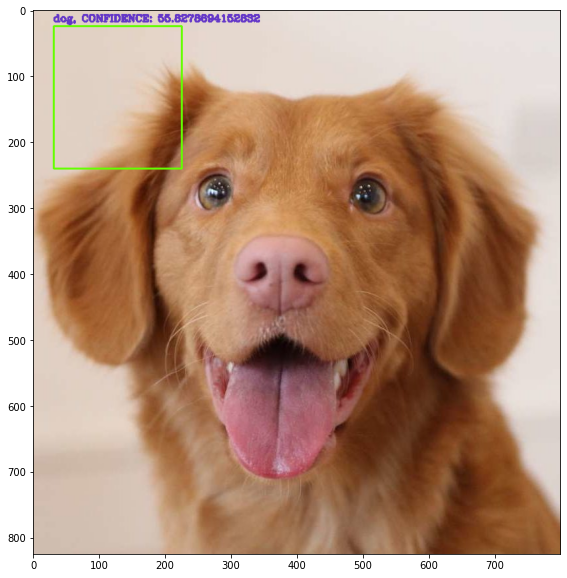

In [25]:
image = '/content/322868_1100-800x825.jpg'
predict(image)